In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix, cohen_kappa_score, 
                           matthews_corrcoef, hamming_loss, roc_auc_score, 
                           precision_recall_curve, log_loss, accuracy_score)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import label_binarize
import cv2
import os
import warnings

warnings.filterwarnings('ignore')

2025-06-23 03:05:53.051200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750647953.253997      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750647953.312807      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')  

print("CUDA warnings suppressed ✓")

CUDA warnings suppressed ✓


In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
IMG_SIZE = 512
BATCH_SIZE = 16
NUM_CLASSES = 8
EPOCHS = 1
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.3

In [4]:
# Read CSV file
df = pd.read_csv('/kaggle/input/combined-fundus-images/Dataset/label_images.csv')

Dataset shape: (9868, 19)
Label distribution:
label
['N']    3230
['D']    1608
['G']    1071
['M']    1036
['C']     897
['O']     888
['A']     708
['H']     430
Name: count, dtype: int64


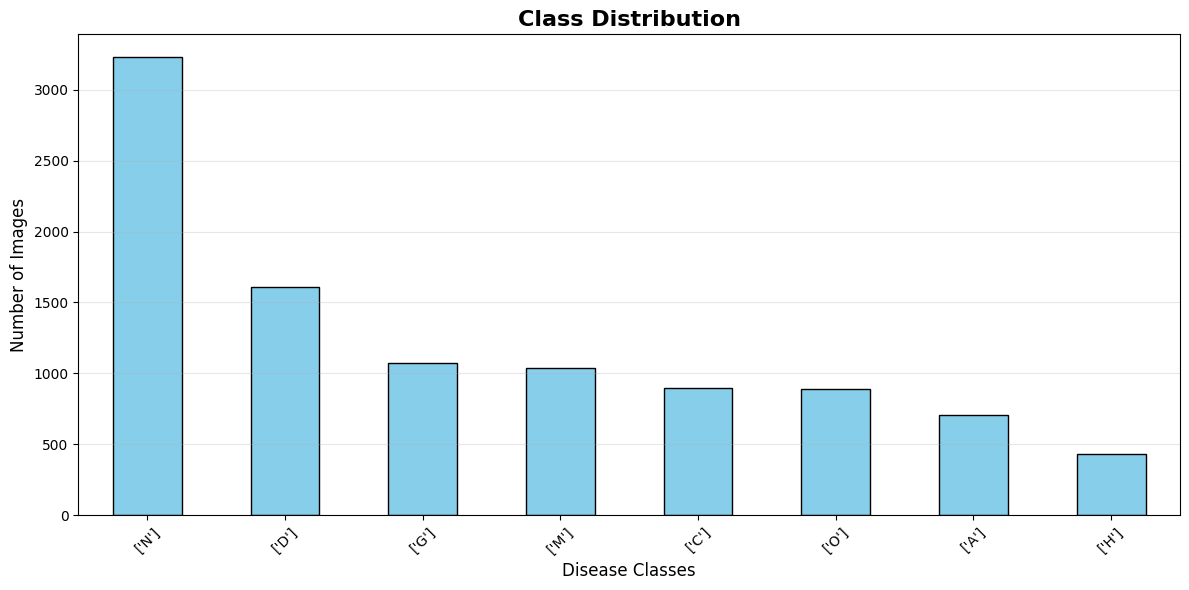

In [5]:
# Display dataset info
print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
df['label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Disease Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# Encode labels
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])
class_names = label_encoder.classes_

In [7]:
# Print the mapping
print("Label Encoding Mapping:")
for idx, class_name in enumerate(class_names):
    print(f"{idx} → {class_name}")


Label Encoding Mapping:
0 → ['A']
1 → ['C']
2 → ['D']
3 → ['G']
4 → ['H']
5 → ['M']
6 → ['N']
7 → ['O']


In [8]:
# Stratified split to ensure balanced distribution in train/test
X = df['images'].values
y = df['encoded_label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

In [9]:
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Create DataFrames for generators
train_df = pd.DataFrame({'images': X_train, 'label': y_train})
test_df = pd.DataFrame({'images': X_test, 'label': y_test})

train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

Training samples: 7894
Testing samples: 1974


In [10]:
# Count labels in train_df
print("Label distribution in train_df:")
print(train_df['label'].value_counts())
print("\n")

# Count labels in test_df
print("Label distribution in test_df:")
print(test_df['label'].value_counts())


Label distribution in train_df:
label
6    2584
2    1286
3     857
5     829
1     718
7     710
0     566
4     344
Name: count, dtype: int64


Label distribution in test_df:
label
6    646
2    322
3    214
5    207
1    179
7    178
0    142
4     86
Name: count, dtype: int64


In [11]:
# Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [12]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='/kaggle/input/combined-fundus-images/Dataset/images/',
    x_col='images',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)


Found 7894 validated image filenames belonging to 8 classes.


In [14]:

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    directory='/kaggle/input/combined-fundus-images/Dataset/images/',
    x_col='images',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 1974 validated image filenames belonging to 8 classes.


In [15]:
# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")


Class weights: {0: 1.7433745583038869, 1: 1.3743036211699164, 2: 0.7673017107309487, 3: 1.1514002333722286, 4: 2.8684593023255816, 5: 1.1902895054282268, 6: 0.3818691950464396, 7: 1.3897887323943663}


In [16]:
# Build the model
def create_model():
    base_model = EfficientNetB6(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT_RATE)(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT_RATE)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(DROPOUT_RATE/2)(x)
    
    predictions = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

In [17]:
model, base_model = create_model()

I0000 00:00:1750647997.228444      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750647997.229217      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


165234480/165234480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
print("Current status:")
print(f"Base model trainable: {base_model.trainable}")

Current status:
Base model trainable: False


In [19]:
# First compile (for stability)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
# NOW make it trainable for full fine-tuning
print("Enabling full fine-tuning...")
base_model.trainable = True

Enabling full fine-tuning...


In [21]:
# Minimal Enhanced Learning Rate Tracker
class LRTracker(tf.keras.callbacks.Callback):
    def __init__(self, verbose=True):
        super().__init__()
        self.lrs = []
        self.verbose = verbose
    
    def on_epoch_end(self, epoch, logs=None):
        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.lrs.append(current_lr)
        
        if self.verbose:
            print(f"Epoch {epoch + 1} - Learning Rate: {current_lr:.2e}")
            
lr_tracker = LRTracker(verbose=True)

In [22]:
model_name = "eye_diseases_model"

# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=f'models/{model_name}.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),

    ModelCheckpoint(
        filepath=f'models/{model_name}.weights.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),

    lr_tracker  
]

steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_test) // BATCH_SIZE

In [23]:
# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
# Print parameter info
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
total_params = sum([tf.keras.backend.count_params(w) for w in model.weights])
print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

Trainable parameters: 42,054,880
Total parameters: 42,284,951.0
Percentage trainable: 99.46%


In [25]:
# Single phase training
print("Starting training...")
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50, 
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("Training completed!")

Starting training...
Epoch 1/50


I0000 00:00:1750648157.337671      96 service.cc:148] XLA service 0x7d01e8023550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750648157.338752      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750648157.338774      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750648171.453647      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1750648186.889192      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750648187.144341      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750648206.403276      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

 49/493 ━━━━━━━━━━━━━━━━━━━━ 12:30 2s/step - accuracy: 0.1554 - loss: 14.2604

E0000 00:00:1750648378.210223      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750648378.395724      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750648388.198601      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750648388.378584      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750648388.993232      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3184 - loss: 13.3668
Epoch 1: val_accuracy improved from -inf to 0.23984, saving model to models/eye_diseases_model.h5

Epoch 1: val_accuracy improved from -inf to 0.23984, saving model to models/eye_diseases_model.weights.h5
Epoch 1 - Learning Rate: 1.00e-04
493/493 ━━━━━━━━━━━━━━━━━━━━ 1268s 2s/step - accuracy: 0.3185 - loss: 13.3655 - val_accuracy: 0.2398 - val_loss: 12.4660 - learning_rate: 1.0000e-04
Epoch 2/50
  1/493 ━━━━━━━━━━━━━━━━━━━━ 13:44 2s/step - accuracy: 0.5000 - loss: 11.8396
Epoch 2: val_accuracy did not improve from 0.23984

Epoch 2: val_accuracy did not improve from 0.23984
Epoch 2 - Learning Rate: 1.00e-04
493/493 ━━━━━━━━━━━━━━━━━━━━ 55s 108ms/step - accuracy: 0.5000 - loss: 11.8396 - val_accuracy: 0.2393 - val_loss: 12.4727 - learning_rate: 1.0000e-04
Epoch 3/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5223 - loss: 11.3097
Epoch 3: val_accuracy did not improve from 0.23984

Epoch 3: val_accuracy d

In [26]:
# Save full Keras model
model.save(f"models/{model_name}.h5")
print(f"✅ Final model saved: models/{model_name}.h5")

# Save only weights
model.save_weights(f"models/{model_name}.weights.h5")
print(f"✅ Weights saved: models/{model_name}.weights.h5")


✅ Final model saved: models/eye_diseases_model.h5
✅ Weights saved: models/eye_diseases_model.weights.h5


In [27]:
import contextlib

# Suppress all stdout/stderr
@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as fnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        try:
            sys.stdout = fnull
            sys.stderr = fnull
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Save TFLite model silently
try:
    with suppress_stdout_stderr():
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        tflite_model = converter.convert()
    
    with open("models/eye_diseases_model.tflite", "wb") as f:
        f.write(tflite_model)
    print("✅ TFLite model saved: models/eye_diseases_model.tflite")
except Exception as e:
    print(f"⚠️ TFLite conversion failed: {e}")

⚠️ TFLite conversion failed: name 'sys' is not defined


In [29]:
# Save training history
import pickle
with open(f'models/{model_name}_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print(f"✅ Training history saved: models/{model_name}_history.pkl")

# Save model summary and info
with open(f'models/{model_name}_info.txt', 'w') as f:
    f.write(f"Model: {model_name}\n")
    f.write(f"Dataset Size: 9,868 images\n")
    f.write(f"Image Size: 512x512\n")
    f.write(f"Architecture: EfficientNetB6\n")
    f.write(f"Total Epochs: {len(history.history['loss'])}\n")
    f.write(f"Best Val Accuracy: {max(history.history['val_accuracy']):.4f}\n")
    f.write(f"Best Val Loss: {min(history.history['val_loss']):.4f}\n")
    f.write("\nModel Summary:\n")
    
    # Redirect model summary to file
    import sys
    from io import StringIO
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()
    model.summary()
    sys.stdout = old_stdout
    f.write(mystdout.getvalue())

print(f"✅ Model info saved: models/{model_name}_info.txt")

Model: "functional"

✅ Training history saved: models/eye_diseases_model_history.pkl


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 512, 512, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 512, 512, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 512, 512, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 513, 513, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 256, 256, 56)   │          1,512 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 256, 256, 56)   │            224 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 256, 256, 56)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 256, 256, 56)   │            504 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 256, 256, 56)   │            224 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 256, 256, 56)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 56)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 56)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 14)       │            798 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 126,394,713 (482.16 MB)

 Trainable params: 42,054,880 (160.43 MB)

 Non-trainable params: 230,071 (898.72 KB)

 Optimizer params: 84,109,762 (320.85 MB)

✅ Model info saved: models/eye_diseases_model_info.txt


In [30]:
# Get predictions for comprehensive evaluation
test_generator.reset()
predictions = model.predict(test_generator, steps=validation_steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes[:len(predicted_classes)]

# Convert to one-hot for multi-label metrics
y_true_onehot = tf.keras.utils.to_categorical(true_classes, NUM_CLASSES)
y_pred_onehot = predictions[:len(true_classes)]

print("\n" + "="*80)
print("COMPREHENSIVE MODEL EVALUATION & VISUALIZATION")
print("="*80)

123/123 ━━━━━━━━━━━━━━━━━━━━ 67s 430ms/step

COMPREHENSIVE MODEL EVALUATION & VISUALIZATION


In [31]:
def plot_training_curves(history, lr_history):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Accuracy
    axes[0, 0].plot(history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history['loss'], label='Training Loss', linewidth=2)
    axes[0, 1].plot(history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 0].plot(lr_history, linewidth=2, color='red')
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    # Hide the unused subplot (bottom right)
    fig.delaxes(axes[1, 1])

    plt.tight_layout()
    plt.show()


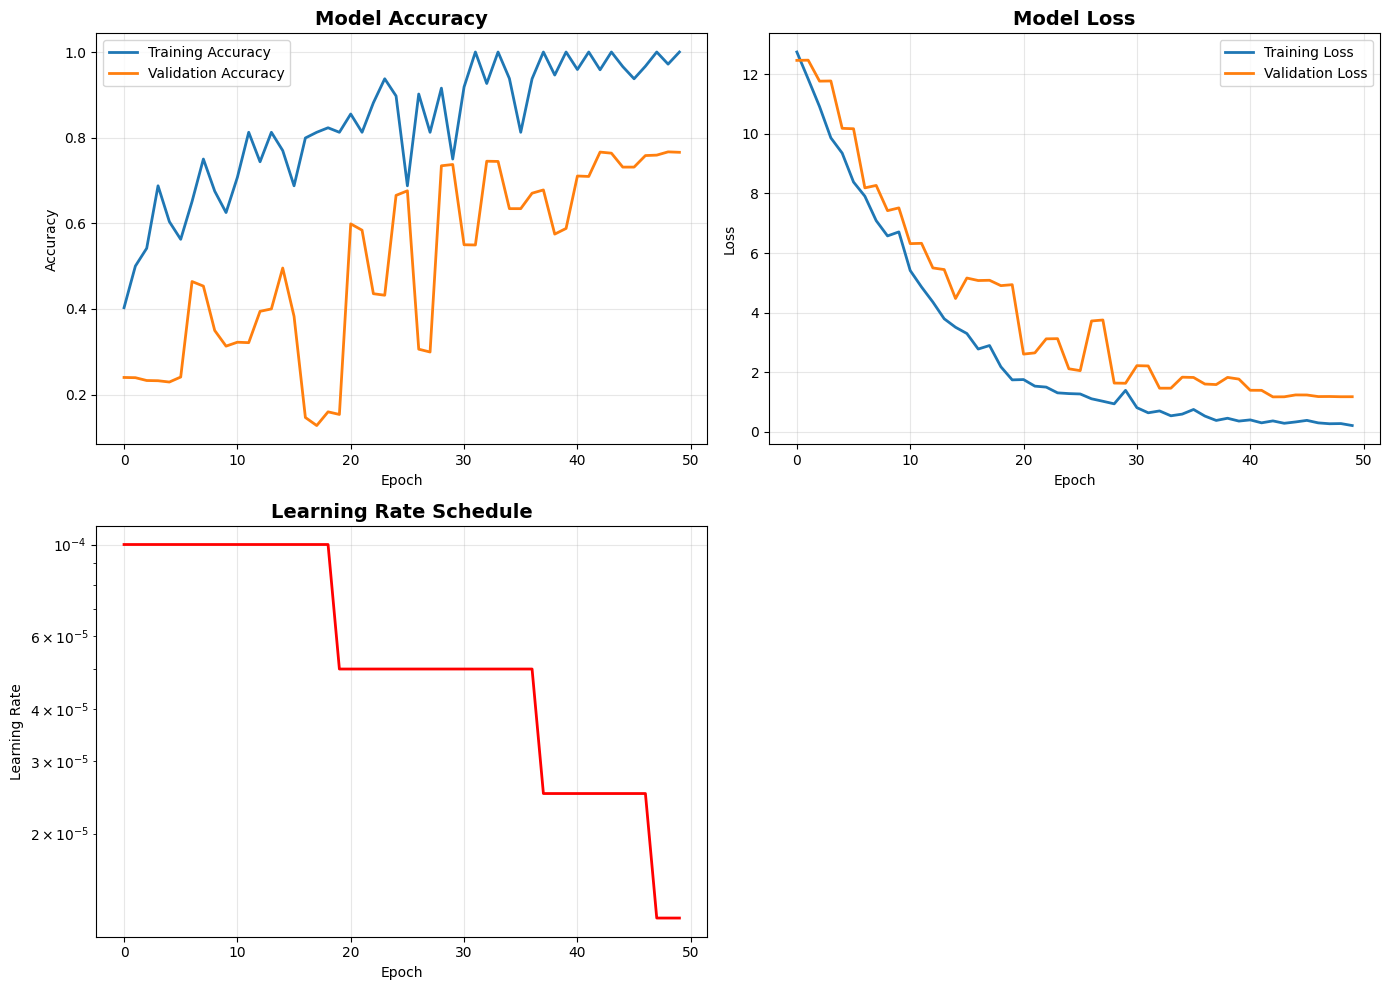

In [32]:
plot_training_curves(history.history, lr_tracker.lrs)

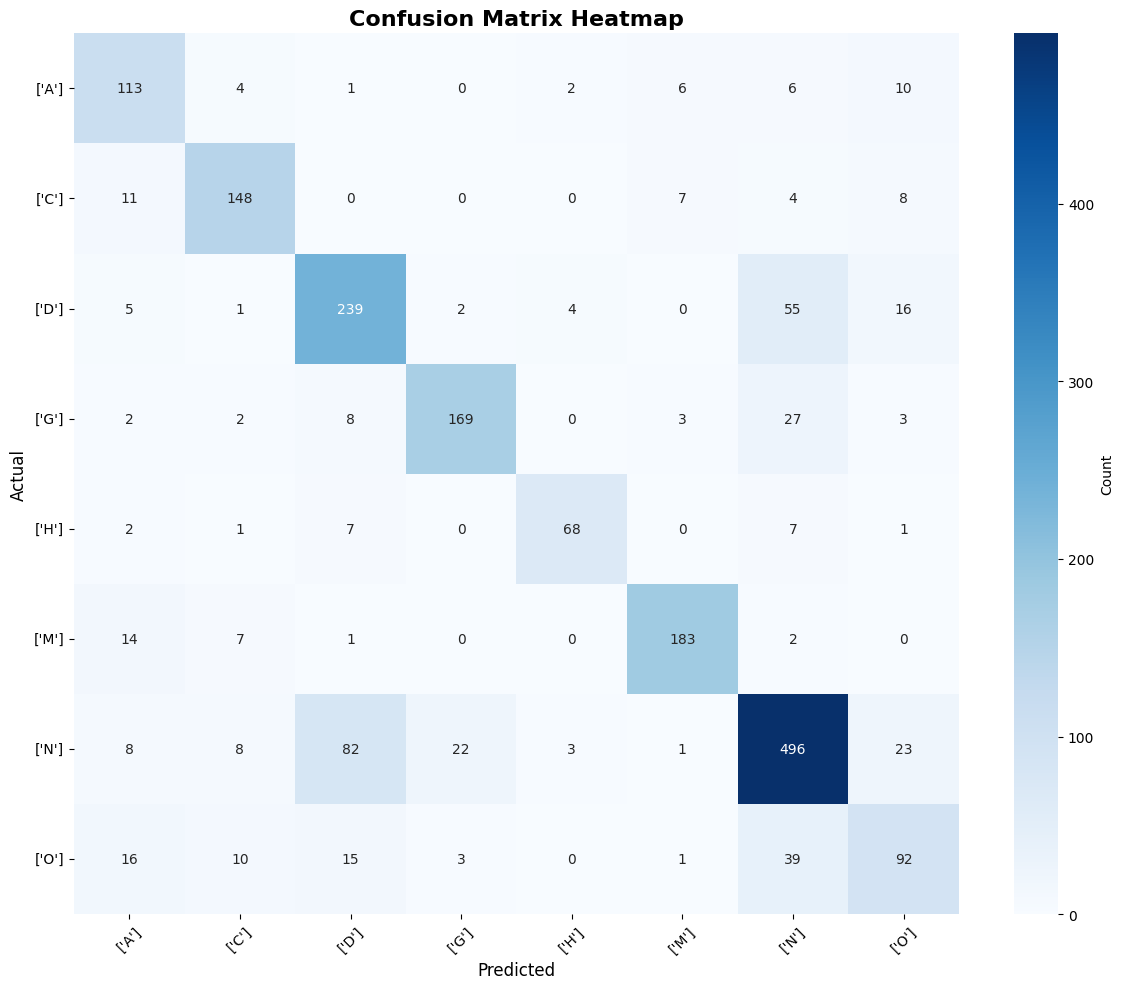

In [33]:
# 2. Confusion Matrix Heatmap
plt.figure(figsize=(12, 10))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [34]:
# 3. Classification Report
print("\n📊 CLASSIFICATION REPORT:")
print("="*50)
print(classification_report(true_classes, predicted_classes, target_names=class_names))


📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       ['A']       0.66      0.80      0.72       142
       ['C']       0.82      0.83      0.82       178
       ['D']       0.68      0.74      0.71       322
       ['G']       0.86      0.79      0.82       214
       ['H']       0.88      0.79      0.83        86
       ['M']       0.91      0.88      0.90       207
       ['N']       0.78      0.77      0.78       643
       ['O']       0.60      0.52      0.56       176

    accuracy                           0.77      1968
   macro avg       0.77      0.77      0.77      1968
weighted avg       0.77      0.77      0.77      1968



In [35]:
# 4. Advanced Metrics
cohen_kappa = cohen_kappa_score(true_classes, predicted_classes)
mcc = matthews_corrcoef(true_classes, predicted_classes)
hamming_loss_score = hamming_loss(y_true_onehot, (y_pred_onehot > 0.5).astype(int))

print(f"\n📈 ADVANCED METRICS:")
print("="*30)
print(f"Cohen's Kappa Score: {cohen_kappa:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Hamming Loss: {hamming_loss_score:.4f}")


📈 ADVANCED METRICS:
Cohen's Kappa Score: 0.7150
Matthews Correlation Coefficient: 0.7154
Hamming Loss: 0.0572


In [36]:
# 5. ROC-AUC Score (One-vs-Rest)
try:
    roc_auc = roc_auc_score(y_true_onehot, y_pred_onehot, multi_class='ovr', average='weighted')
    print(f"ROC-AUC Score (Weighted): {roc_auc:.4f}")
except:
    print("ROC-AUC Score: Could not compute (insufficient class representation)")


ROC-AUC Score (Weighted): 0.9442


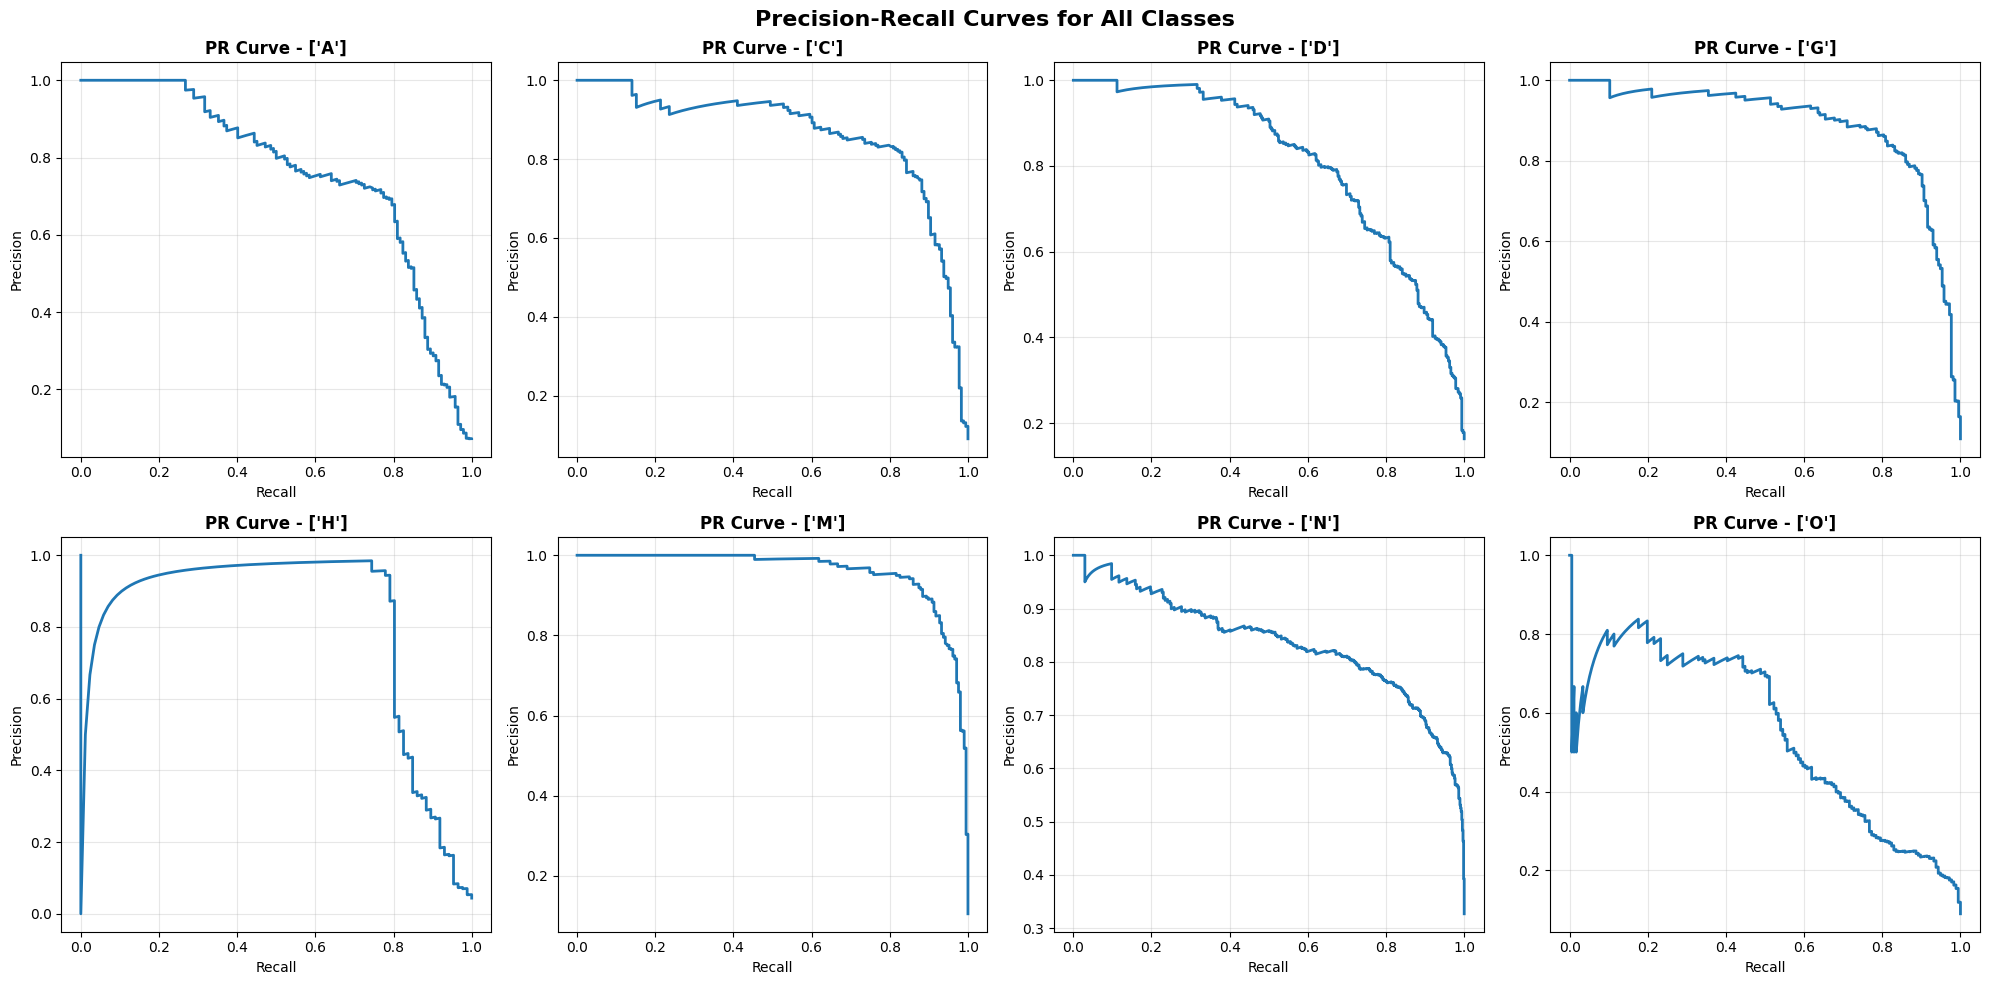

In [38]:
# 6. Precision-Recall Curves
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i in range(NUM_CLASSES):
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_pred_onehot[:, i])
    axes[i].plot(recall, precision, linewidth=2)
    axes[i].set_title(f'PR Curve - {class_names[i]}', fontweight='bold')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Precision-Recall Curves for All Classes', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

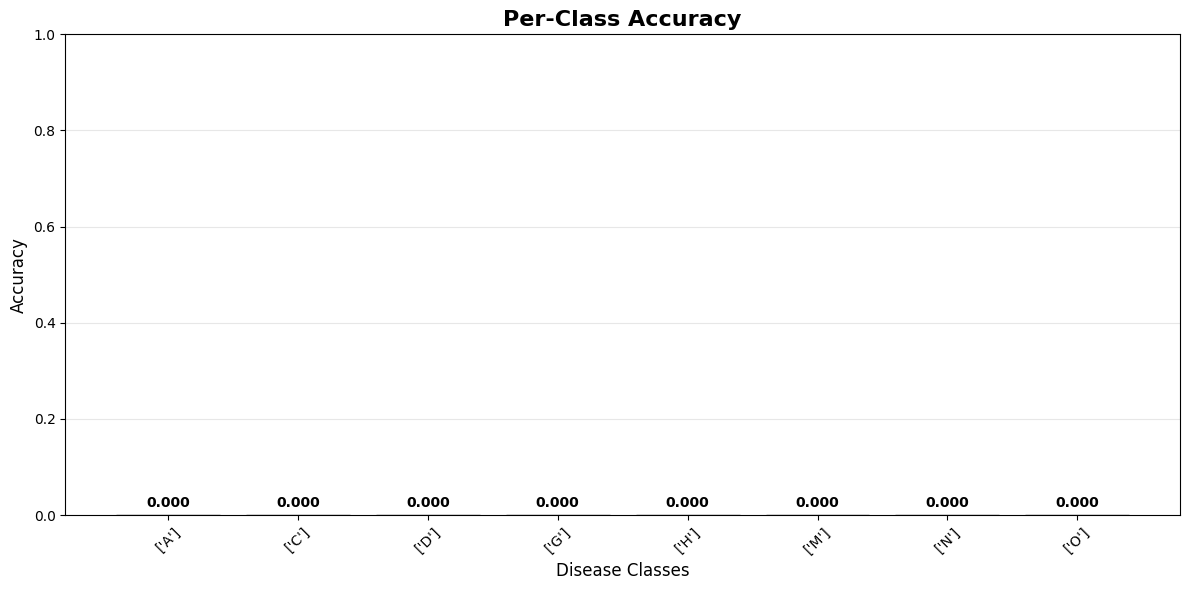

In [39]:
# 7. Per-Class Accuracy Bar Plot
per_class_accuracy = []
for i in range(NUM_CLASSES):
    class_mask = (true_classes == i)
    if np.sum(class_mask) > 0:
        class_acc = accuracy_score(true_classes[class_mask], predicted_classes[class_mask])
        per_class_accuracy.append(class_acc)
    else:
        per_class_accuracy.append(0)

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, per_class_accuracy, color='lightcoral', alpha=0.8, edgecolor='black')
plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Disease Classes', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, per_class_accuracy):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [40]:
# 8. Feature Extraction for t-SNE/UMAP
print("\n🔍 Extracting features for dimensionality reduction...")
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
test_generator.reset()
features = feature_extractor.predict(test_generator, steps=validation_steps, verbose=1)
features = features[:len(true_classes)]


🔍 Extracting features for dimensionality reduction...
123/123 ━━━━━━━━━━━━━━━━━━━━ 67s 425ms/step


Computing t-SNE embedding...


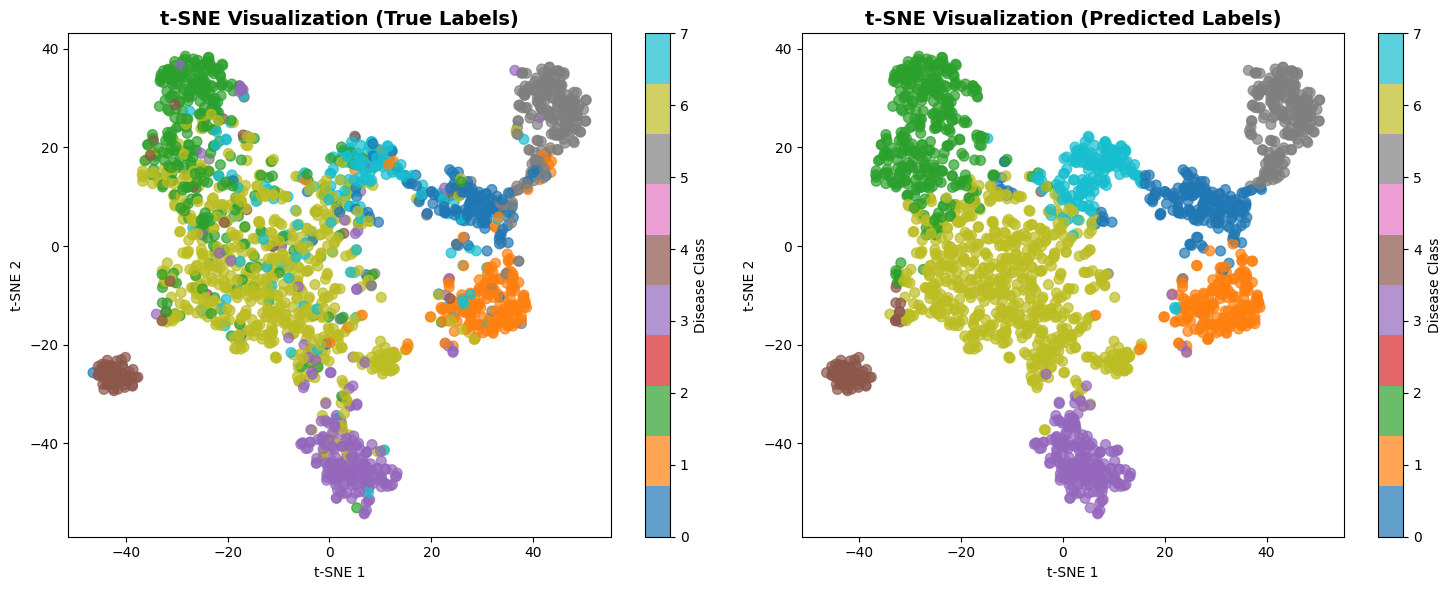

In [41]:
# 9. t-SNE Visualization
print("Computing t-SNE embedding...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_features = tsne.fit_transform(features)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], 
                     c=true_classes, cmap='tab10', alpha=0.7, s=50)
plt.title('t-SNE Visualization (True Labels)', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter, ticks=range(NUM_CLASSES), label='Disease Class')

plt.subplot(1, 2, 2)
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], 
                     c=predicted_classes, cmap='tab10', alpha=0.7, s=50)
plt.title('t-SNE Visualization (Predicted Labels)', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter, ticks=range(NUM_CLASSES), label='Disease Class')

plt.tight_layout()
plt.show()

Computing UMAP embedding...


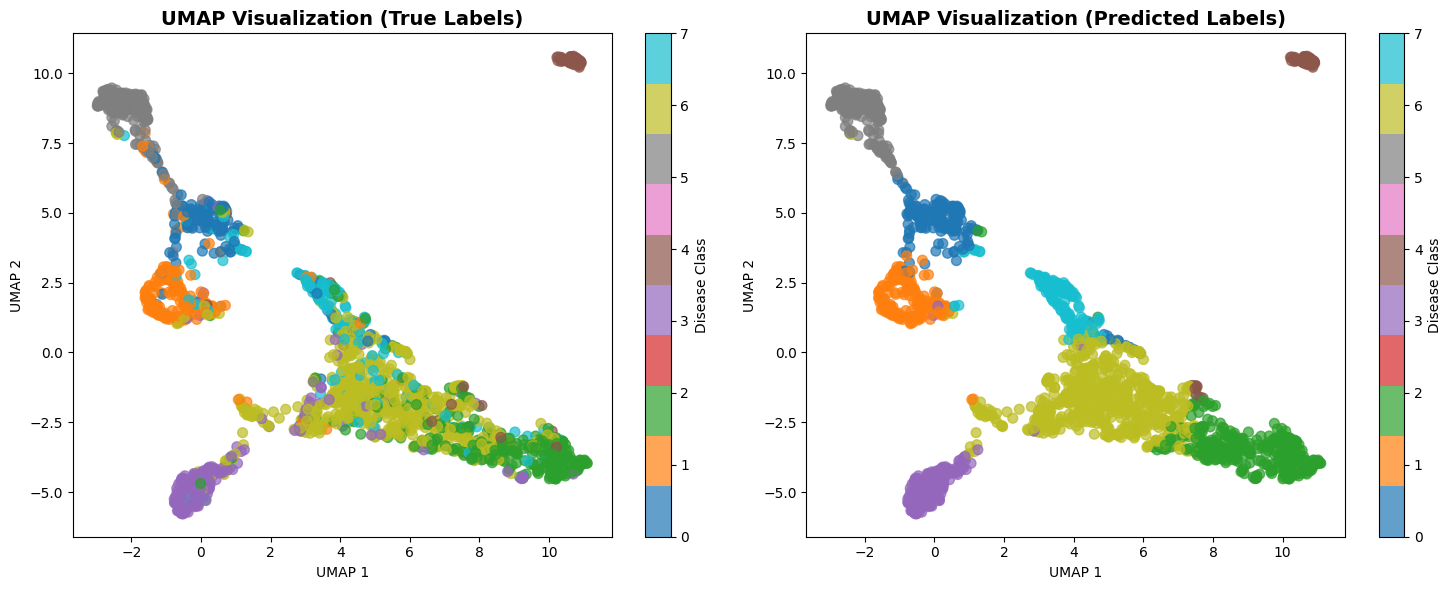

In [42]:
# 10. UMAP Visualization
print("Computing UMAP embedding...")
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_features = umap_reducer.fit_transform(features)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(umap_features[:, 0], umap_features[:, 1], 
                     c=true_classes, cmap='tab10', alpha=0.7, s=50)
plt.title('UMAP Visualization (True Labels)', fontsize=14, fontweight='bold')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(scatter, ticks=range(NUM_CLASSES), label='Disease Class')

plt.subplot(1, 2, 2)
scatter = plt.scatter(umap_features[:, 0], umap_features[:, 1], 
                     c=predicted_classes, cmap='tab10', alpha=0.7, s=50)
plt.title('UMAP Visualization (Predicted Labels)', fontsize=14, fontweight='bold')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(scatter, ticks=range(NUM_CLASSES), label='Disease Class')

plt.tight_layout()
plt.show()

Generating Grad-CAM visualizations...
Using layer: top_conv


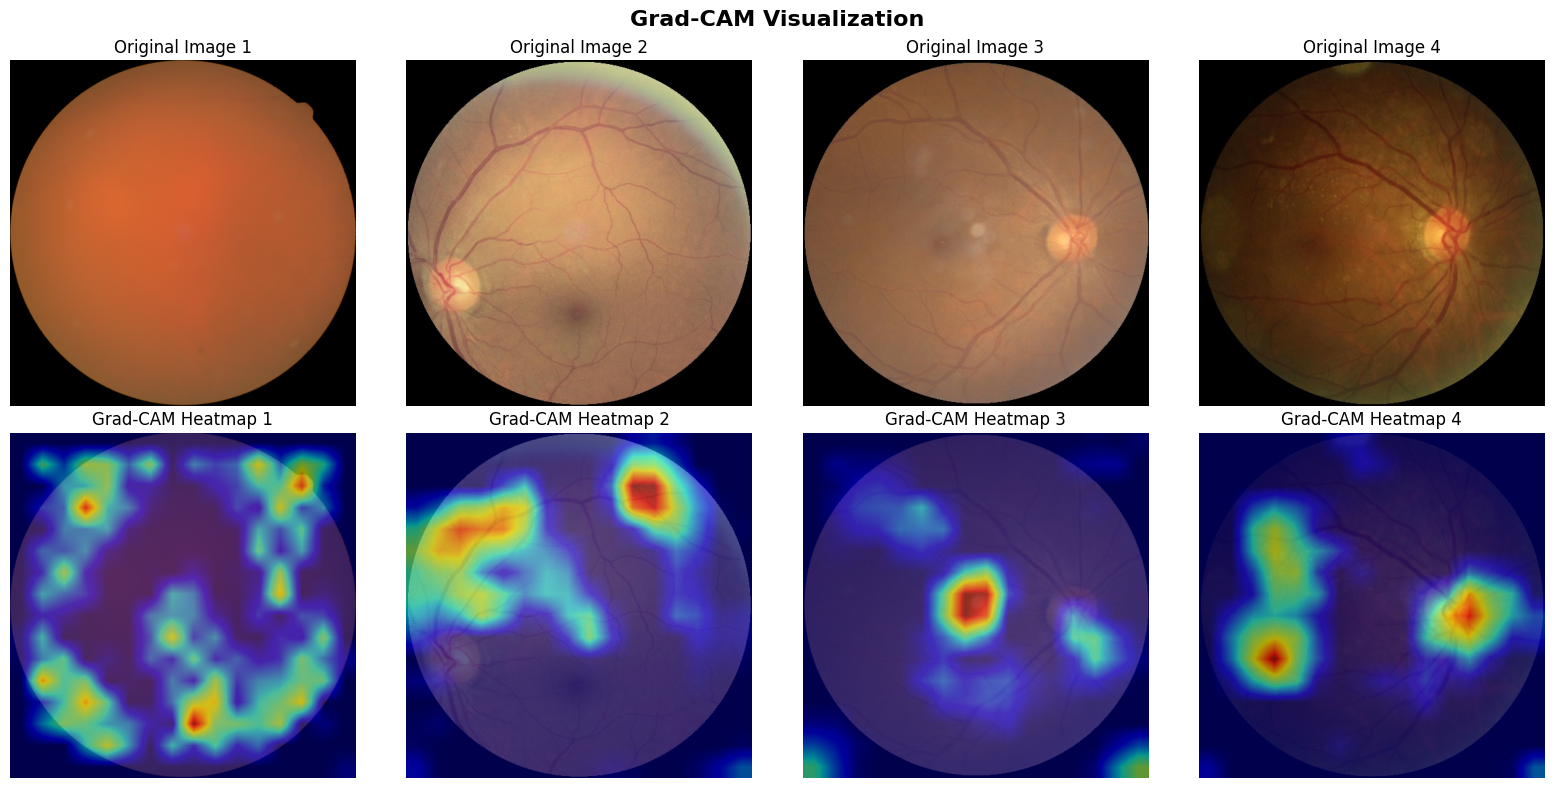

In [44]:
# Fixed Grad-CAM visualization
def visualize_gradcam_samples():
    """Visualize Grad-CAM for sample images"""
    print("Generating Grad-CAM visualizations...")
    
    # Get some test images
    test_generator.reset()
    sample_batch, sample_labels = next(test_generator)
    
    # Find the last convolutional layer - corrected approach
    last_conv_layer_name = None
    
    # Method 1: If model has a base_model (like when using transfer learning)
    if hasattr(model, 'layers') and len(model.layers) > 0:
        # Check if first layer is a base model (like EfficientNet)
        base_model = None
        for layer in model.layers:
            if hasattr(layer, 'layers') and len(layer.layers) > 0:
                base_model = layer
                break
        
        if base_model:
            # Search in the base model layers
            for layer in reversed(base_model.layers):
                if len(layer.output_shape) == 4:  # Conv layer has 4D output
                    last_conv_layer_name = layer.name
                    break
        else:
            # Search in main model layers
            for layer in reversed(model.layers):
                if hasattr(layer, 'output_shape') and len(layer.output_shape) == 4:
                    last_conv_layer_name = layer.name
                    break
    
    # Method 2: Alternative approach - search by layer type
    if not last_conv_layer_name:
        for layer in reversed(model.layers):
            if 'conv' in layer.name.lower() or 'Conv' in str(type(layer)):
                last_conv_layer_name = layer.name
                break
    
    # Method 3: Print layer info for debugging
    if not last_conv_layer_name:
        print("Model structure:")
        for i, layer in enumerate(model.layers):
            print(f"Layer {i}: {layer.name} - {type(layer)} - {getattr(layer, 'output_shape', 'No output_shape')}")
            if hasattr(layer, 'layers'):
                print(f"  Sublayers in {layer.name}:")
                for j, sublayer in enumerate(layer.layers[-5:]):  # Show last 5 sublayers
                    print(f"    {j}: {sublayer.name} - {type(sublayer)} - {getattr(sublayer, 'output_shape', 'No output_shape')}")
    
    if last_conv_layer_name:
        print(f"Using layer: {last_conv_layer_name}")
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        
        for i in range(min(4, len(sample_batch))):
            img = sample_batch[i:i+1]
            
            # Generate heatmap
            heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
            
            # Display original image
            axes[0, i].imshow(sample_batch[i])
            axes[0, i].set_title(f'Original Image {i+1}')
            axes[0, i].axis('off')
            
            # Display heatmap overlay
            axes[1, i].imshow(sample_batch[i])
            axes[1, i].imshow(heatmap, alpha=0.6, cmap='jet')
            axes[1, i].set_title(f'Grad-CAM Heatmap {i+1}')
            axes[1, i].axis('off')
        
        plt.suptitle('Grad-CAM Visualization', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("Could not find convolutional layer for Grad-CAM")
        print("Available layers:")
        for layer in model.layers:
            print(f"- {layer.name}: {type(layer)}")

# Also, make sure your make_gradcam_heatmap function is robust
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap
    """
    import tensorflow as tf
    
    # Remove last layer's softmax
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # Gradient of the output neuron (top predicted or chosen)
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel in the feature map array by "how important this channel is"
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    # Resize heatmap to original image size
    heatmap_resized = tf.image.resize(heatmap[..., tf.newaxis], (512, 512))
    
    return heatmap_resized.numpy()

# Run the visualization
try:
    visualize_gradcam_samples()
except Exception as e:
    print(f"Grad-CAM visualization failed: {str(e)}")
    import traceback
    traceback.print_exc()

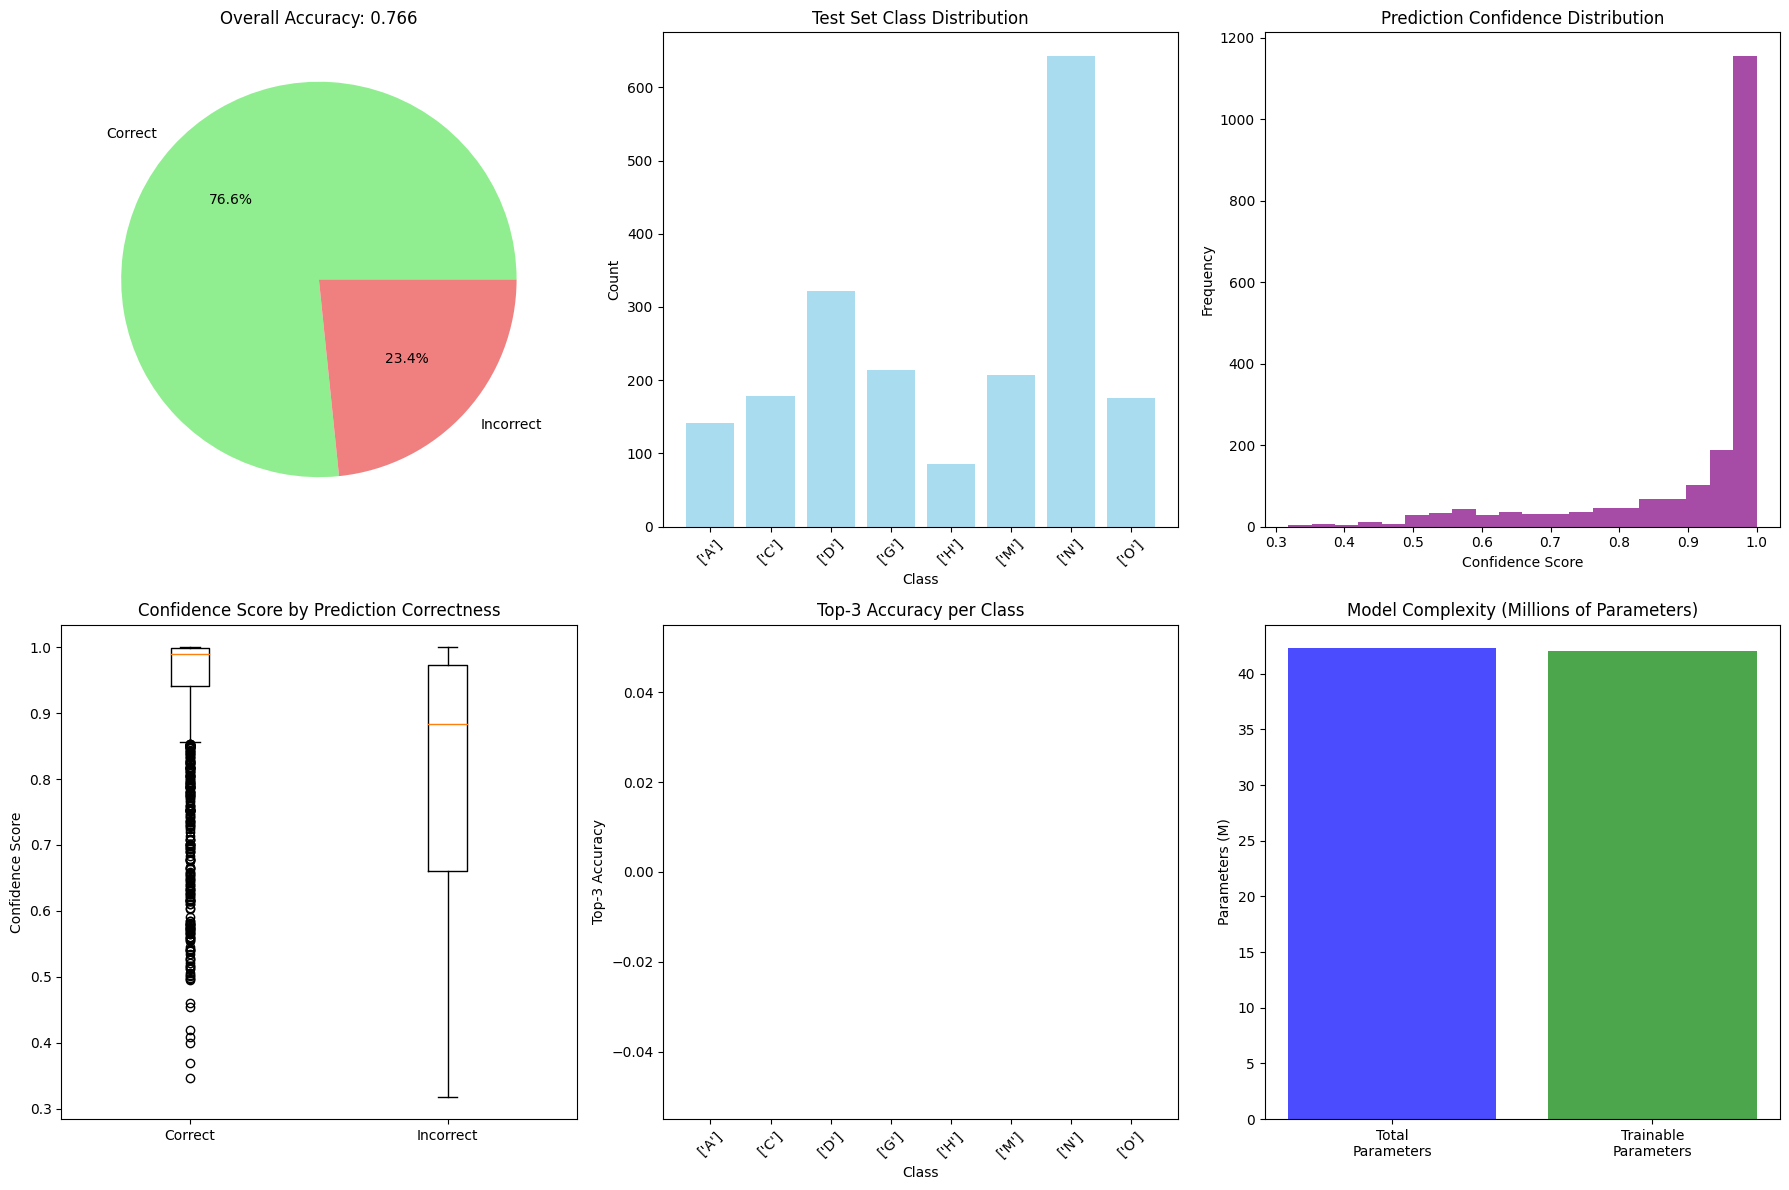

In [45]:
# 12. Summary Metrics Dashboard
def create_metrics_dashboard():
    """Create a comprehensive metrics dashboard"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Overall accuracy
    overall_acc = accuracy_score(true_classes, predicted_classes)
    axes[0, 0].pie([overall_acc, 1-overall_acc], labels=['Correct', 'Incorrect'], 
                   autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
    axes[0, 0].set_title(f'Overall Accuracy: {overall_acc:.3f}')
    
    # Class distribution in test set
    unique, counts = np.unique(true_classes, return_counts=True)
    axes[0, 1].bar(range(len(unique)), counts, color='skyblue', alpha=0.7)
    axes[0, 1].set_title('Test Set Class Distribution')
    axes[0, 1].set_xlabel('Class')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_xticks(range(len(unique)))
    axes[0, 1].set_xticklabels([class_names[i] for i in unique], rotation=45)
    
    # Prediction confidence distribution
    confidence_scores = np.max(y_pred_onehot, axis=1)
    axes[0, 2].hist(confidence_scores, bins=20, alpha=0.7, color='purple')
    axes[0, 2].set_title('Prediction Confidence Distribution')
    axes[0, 2].set_xlabel('Confidence Score')
    axes[0, 2].set_ylabel('Frequency')
    
    # Error analysis
    correct_predictions = (true_classes == predicted_classes)
    correct_conf = confidence_scores[correct_predictions]
    incorrect_conf = confidence_scores[~correct_predictions]
    
    axes[1, 0].boxplot([correct_conf, incorrect_conf], labels=['Correct', 'Incorrect'])
    axes[1, 0].set_title('Confidence Score by Prediction Correctness')
    axes[1, 0].set_ylabel('Confidence Score')
    
    # Top-3 accuracy per class
    top3_per_class = []
    for i in range(NUM_CLASSES):
        class_mask = (true_classes == i)
        if np.sum(class_mask) > 0:
            class_preds = y_pred_onehot[class_mask]
            class_true = y_true_onehot[class_mask]
            top3_acc = tf.keras.metrics.top_k_categorical_accuracy(class_true, class_preds, k=3).numpy().mean()
            top3_per_class.append(top3_acc)
        else:
            top3_per_class.append(0)
    
    axes[1, 1].bar(range(NUM_CLASSES), top3_per_class, color='orange', alpha=0.7)
    axes[1, 1].set_title('Top-3 Accuracy per Class')
    axes[1, 1].set_xlabel('Class')
    axes[1, 1].set_ylabel('Top-3 Accuracy')
    axes[1, 1].set_xticks(range(NUM_CLASSES))
    axes[1, 1].set_xticklabels(class_names, rotation=45)
    
    # Model complexity vs performance
    total_params = model.count_params()
    trainable_params = int(np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights]))
    
    axes[1, 2].bar(['Total\nParameters', 'Trainable\nParameters'], 
                   [total_params/1e6, trainable_params/1e6], 
                   color=['blue', 'green'], alpha=0.7)
    axes[1, 2].set_title('Model Complexity (Millions of Parameters)')
    axes[1, 2].set_ylabel('Parameters (M)')
    
    plt.tight_layout()
    plt.show()

create_metrics_dashboard()

In [46]:
# Final evaluation summary
print("\n📈 FINAL EVALUATION METRICS:")
print("="*50)

test_loss, test_accuracy = model.evaluate(
    test_generator, 
    steps=validation_steps,
    verbose=0
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Total Model Parameters: {model.count_params():,}")
print(f"Trainable Parameters: {int(np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])):,}")



📈 FINAL EVALUATION METRICS:
Test Loss: 1.1706
Test Accuracy: 0.7663
Total Model Parameters: 42,284,951
Trainable Parameters: 42,054,880
